# Noiseless QCNN demo for Model3

This is noiseless QCNN demonstration for Model 3. 

The objective of this demonstration is different from Model 1/2 QCNN demos.

Model 1/2 QCNN demo compares QCNN performance with / without pre-training the quantum embedding.

Instead for Model 3 (as Model 3 can't be used without pre-traing unlike Model 1), I will compare QCNN performances between

1) Train CNN First with Model3_Fidelity. Then train parameterized QCNN.

2) Train parameterized embedding + parameterized QCNN all together as one optimization problem.


# 1. Load Noiseless Device

In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.insert(0, '/Users/tak/Github/QEmbedding/')
import Hybrid_nn
import torch
from torch import nn
import data
import pennylane as qml
import embedding

dev = qml.device('default.qubit', wires=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Feature Mapping Circuit

In [2]:

N_layers = 3

# 8 Feature Encoding in 4 qubit circuits
def Four_QuantumEmbedding2(input):
    for i in range(N_layers):
        for j in range(4):
            qml.Hadamard(wires=j)
            embedding.exp_Z(input[j], wires=j)
        for k in range(3):
            embedding.exp_ZZ1(input[4+k], wires=[k, k+1])
        embedding.exp_ZZ1(input[7], wires=[3,0])                       

def Four_QuantumEmbedding2_inverse(input):
    for i in range(N_layers):
        embedding.exp_ZZ1(input[7], wires=[3,0], inverse=True) 
        for k in reversed(range(3)):
            embedding.exp_ZZ1(input[k+4], wires=[k,k+1], inverse=True)
        qml.Barrier()
        for j in range(4):
            embedding.exp_Z(input[j], wires=j, inverse=True)
            qml.Hadamard(wires=j)

In [3]:
@qml.qnode(dev, interface="torch")
def circuit3(inputs): 
    Four_QuantumEmbedding2(inputs[0:8])
    Four_QuantumEmbedding2_inverse(inputs[8:16])
    return qml.probs(wires=range(4))


class Four_Model3_Fidelity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Layer1: 28 * 28 -> 14 * 14
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 8
        self.fc = torch.nn.Linear(7 * 7, 8, bias=True)

        self.qlayer3 = qml.qnn.TorchLayer(circuit3, weight_shapes={})

    def forward(self, x1, x2):
        x1 = self.layer1(x1)
        x1 = self.layer2(x1)
        x1 = x1.view(-1, 7 * 7)
        x1 = self.fc(x1)

        x2 = self.layer1(x2)
        x2 = self.layer2(x2)
        x2 = x2.view(-1, 7 * 7)
        x2 = self.fc(x2)

        x = torch.concat([x1, x2], 1)
        x = self.qlayer3(x)
        return x[:,0]

class Four_Model3_HSinner(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.matrix_fn3 = qml.matrix(circuit3)
        # Layer1: 28 * 28 -> 14 * 14
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 8
        self.fc = torch.nn.Linear(7 * 7, 8, bias=True)


    def forward(self, x1, x2):
        x1 = self.layer1(x1)
        x1 = self.layer2(x1)
        x1 = x1.view(-1, 7 * 7)
        x1 = self.fc(x1)

        x2 = self.layer1(x2)
        x2 = self.layer2(x2)
        x2 = x2.view(-1, 7 * 7)
        x2 = self.fc(x2)

        
        x = torch.concat([x1, x2], 1).to("cpu")
        x = [torch.real(torch.trace(self.matrix_fn3(a))) for a in x]
        x = torch.stack(x, dim=0).to(device)
        return x / 2**4

Draw the circuit and check if everything is alright.

In [4]:

print("Circuit3: \n")
print(
    qml.draw(
        circuit3,
        expansion_strategy="device",
        show_matrices=False
    )([1,2,3,4,5,6,7,8,1,2,3,4,5,6,7,8])
)

Circuit3: 

0: ──H──RZ(-2.00)─╭●─────────────╭●─────────────────────────────────────╭X──RZ(-16.00)─╭X──H
1: ──H──RZ(-4.00)─╰X──RZ(-10.00)─╰X─╭●─────────────╭●───────────────────│──────────────│───H
2: ──H──RZ(-6.00)───────────────────╰X──RZ(-12.00)─╰X─╭●─────────────╭●─│──────────────│───H
3: ──H──RZ(-8.00)─────────────────────────────────────╰X──RZ(-14.00)─╰X─╰●─────────────╰●──H

───RZ(-2.00)─╭●─────────────╭●─────────────────────────────────────╭X──RZ(-16.00)─╭X──H──RZ(-2.00)
───RZ(-4.00)─╰X──RZ(-10.00)─╰X─╭●─────────────╭●───────────────────│──────────────│───H──RZ(-4.00)
───RZ(-6.00)───────────────────╰X──RZ(-12.00)─╰X─╭●─────────────╭●─│──────────────│───H──RZ(-6.00)
───RZ(-8.00)─────────────────────────────────────╰X──RZ(-14.00)─╰X─╰●─────────────╰●──H──RZ(-8.00)

──╭●─────────────╭●─────────────────────────────────────╭X──RZ(-16.00)─╭X─╭X──RZ(16.00)─╭X───
──╰X──RZ(-10.00)─╰X─╭●─────────────╭●───────────────────│──────────────│──│─────────────│────
────────────────────╰X──RZ(-12

# 3. Load Datasets

In [5]:
feature_reduction = False
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
def new_data(batch_size, X, Y):
    X1_new, X2_new, Y_new = [], [], []
    for i in range(batch_size):
        n, m = np.random.randint(len(X)), np.random.randint(len(X))
        X1_new.append(X[n])
        X2_new.append(X[m])
        if Y[n] == Y[m]:
            Y_new.append(1)
        else:
            Y_new.append(0)

    X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)
    if feature_reduction == False:
        X1_new = X1_new.permute(0, 3, 1, 2)
        X2_new = X2_new.permute(0, 3, 1, 2)
    return X1_new.to(device), X2_new.to(device), Y_new.to(device)

N_valid, N_test = 500, 1000
X1_new_valid, X2_new_valid, Y_new_valid = new_data(N_valid, X_test, Y_test)
X1_new_test, X2_new_test, Y_new_test = new_data(N_test, X_test, Y_test)

/opt/anaconda3/envs/QC/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835196/work/torch/csrc/utils/tensor_new.cpp:233.)
  from ipykernel import kernelapp as app


# 4. Train Models

Train Model3_Fidelity and Model3_HSinner

In [6]:
def train_models(model_name):
    train_loss = []
    if model_name == 'Four_Model3_Fidelity':
        model = Four_Model3_Fidelity()
        PATH = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noiseless/Model 3/Four_Model3_Fidelity.pt'
    elif model_name == 'Four_Model3_HSinner':
        model = Four_Model3_HSinner()
        PATH = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noiseless/Model 3/Four_Model3_HSinner.pt'
    model.train()

    loss_fn = torch.nn.MSELoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.01)
    for it in range(1000):
        X1_batch, X2_batch, Y_batch = new_data(25, X_train, Y_train)
        X1_batch, X2_batch, Y_batch = X1_batch, X2_batch, Y_batch

        pred = model(X1_batch, X2_batch)
        pred, Y_batch = pred.to(torch.float32), Y_batch.to(torch.float32)
        loss = loss_fn(pred, Y_batch)
        train_loss.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()

        if it % 200 == 0:
            print(f"Iterations: {it} Loss: {loss.item()}")
    
    torch.save(model.state_dict(), PATH)



Train Four_Model3_Fidelity

In [ ]:
train_models('Four_Model3_Fidelity')

Train Four_Model3_HSinner

In [7]:
train_models('Four_Model3_HSinner')

Iterations: 0 Loss: 0.472064733505249
Iterations: 200 Loss: 0.03998862951993942
Iterations: 400 Loss: 0.02271457202732563
Iterations: 600 Loss: 0.026655469089746475
Iterations: 800 Loss: 0.004530478268861771


# 5. Check the distances before and after the training.

Separate the data of two binary classes.

In [8]:
X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test).to(torch.float32), torch.tensor(X0_test).to(torch.float32)
X1_test, X0_test = X1_test.permute(0, 3, 1, 2), X0_test.permute(0, 3, 1, 2)

X1_train, X0_train = [], []
for i in range(len(X_train)):
    if Y_train[i] == 1:
        X1_train.append(X_train[i])
    else:
        X0_train.append(X_train[i])
X1_train, X0_train = torch.tensor(X1_train).to(torch.float32), torch.tensor(X0_train).to(torch.float32)
X1_train, X0_train = X1_train.permute(0, 3, 1, 2), X0_train.permute(0, 3, 1, 2)

Distance Measuring Models

In [9]:
dev = qml.device('default.qubit', wires=4)
@qml.qnode(dev, interface="torch")
def Four_Distance3(inputs): 
    Four_QuantumEmbedding2(inputs[0:8])
    return qml.density_matrix(wires=range(4))


class Distances(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Layer1: 28 * 28 -> 14 * 14
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 8
        self.fc = torch.nn.Linear(7 * 7, 8, bias=True)
        self.qlayer3_distance = qml.qnn.TorchLayer(Four_Distance3, weight_shapes={})

    def forward(self, x1, x0):
        x1 = self.layer1(x1)
        x1 = self.layer2(x1)
        x1 = x1.view(-1, 7 * 7)
        x1 = self.fc(x1)

        x0 = self.layer1(x0)
        x0 = self.layer2(x0)
        x0 = x0.view(-1, 7 * 7)
        x0 = self.fc(x0)

        rhos1 = self.qlayer3_distance(x1)
        rhos0 = self.qlayer3_distance(x0)
        
        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        eigvals = torch.linalg.eigvals(rho_diff)
        return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))


PATH_Four_Model3_Fidelity = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noiseless/Model 3/Four_Model3_Fidelity.pt'
PATH_Four_Model3_HSinner = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noiseless/Model 3/Four_Model3_HSinner.pt'

D_Four_Model3_Fidelity = Distances()
D_Four_Model3_Fidelity.load_state_dict(torch.load(PATH_Four_Model3_Fidelity))

D_Four_Model3_HSinner = Distances()
D_Four_Model3_HSinner.load_state_dict(torch.load(PATH_Four_Model3_HSinner))

<All keys matched successfully>

Distance Measure after training with Four_Model3_Fidelity and Four_Model3_HSinner

In [10]:
D_Four_Model3_Fidelity_traindata = D_Four_Model3_Fidelity(X1_train, X0_train)
D_Four_Model3_HSinner_traindata = D_Four_Model3_HSinner(X1_train, X0_train)
print(f"Trace Distance (Training Data) After Four_Model3_Fidelity: {D_Four_Model3_Fidelity_traindata}")
print(f"Trace Distance (Training Data) After Four_Model3_HSinner: {D_Four_Model3_HSinner_traindata}")

D_Four_Model3_Fidelity_testdata = D_Four_Model3_Fidelity(X1_test, X0_test)
D_Four_Model3_HSinner_testdata = D_Four_Model3_HSinner(X1_test, X0_test)
print(f"Trace Distance (Test Data) After Four_Model3_Fidelity: {D_Four_Model3_Fidelity_testdata}")
print(f"Trace Distance (Test Data) After Four_Model3_HSinner: {D_Four_Model3_HSinner_testdata}")

/opt/anaconda3/envs/QC/lib/python3.7/site-packages/pennylane/qnn/torch.py:328: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835196/work/aten/src/ATen/native/Copy.cpp:250.)
  return self.qnode(**kwargs).type(x.dtype)


Trace Distance (Training Data) After Four_Model3_Fidelity: 0.9146187901496887
Trace Distance (Training Data) After Four_Model3_HSinner: 0.6774505972862244
Trace Distance (Test Data) After Four_Model3_Fidelity: 0.9234922528266907
Trace Distance (Test Data) After Four_Model3_HSinner: 0.6806151866912842


Calculate the lower bounds

In [11]:
LB_Four_Model3_Fidelity = 0.5 * (1 - D_Four_Model3_Fidelity_traindata.detach().numpy())
LB_Four_Model3_HSinner = 0.5 * (1 - D_Four_Model3_HSinner_traindata.detach().numpy())

print(f"Sample Loss Lower Bound After Four_Model3_Fidelity: {LB_Four_Model3_Fidelity}")
print(f"Sample Loss Lower Bound After Four_Model3_HSinner: {LB_Four_Model3_HSinner}")

Sample Loss Lower Bound After Four_Model3_Fidelity: 0.04269060492515564
Sample Loss Lower Bound After Four_Model3_HSinner: 0.16127470135688782


# 6. Training QCNN

Relabel the datasets

In [27]:
X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
X_train, X_test = X_train.permute(0, 3, 1, 2), X_test.permute(0, 3, 1, 2)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [13]:
class x_transform(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 8
        self.fc = torch.nn.Linear(7 * 7, 8, bias=True)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 7 * 7)
        x = self.fc(x)
        return x.detach().numpy()

x_transform_Four_Model3_Fidelity = x_transform()
x_transform_Four_Model3_HSinner = x_transform()

x_transform_Four_Model3_Fidelity.load_state_dict(torch.load(PATH_Four_Model3_Fidelity))
x_transform_Four_Model3_HSinner.load_state_dict(torch.load(PATH_Four_Model3_HSinner))

<All keys matched successfully>

Prepare QCNN classifier circuits

In [16]:
def statepreparation(x, Trained):

    if Trained == 'Four_Model3_Fidelity':
        x = x_transform_Four_Model3_Fidelity(torch.tensor(x))
        Four_QuantumEmbedding2(x[0])


    elif Trained == 'Four_Model3_HSinner':
        x = x_transform_Four_Model3_HSinner(torch.tensor(x))
        Four_QuantumEmbedding2(x[0])


# Trainable Ansatze
def SU_4(params, wires): # 15 params
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])


def QCNN_four(params):
    param1 = params[0:15]
    param2 = params[15:30]
    SU_4(param1, wires=[0, 1])
    SU_4(param1, wires=[2, 3])
    SU_4(param1, wires=[1, 2])
    SU_4(param1, wires=[3, 0])
    SU_4(param2, wires=[0, 2])


@qml.qnode(dev)
def QCNN_classifier(params, x, Trained):
    statepreparation(x, Trained)
    qml.Barrier()
    QCNN_four(params)
    return qml.expval(qml.PauliZ(2))

def Linear_Loss(labels, predictions):
    loss = 0
    for l,p in zip(labels, predictions):
        loss += 0.5 * (1 - l * p)
    return loss / len(labels)

def cost(weights, X_batch, Y_batch, Trained):
    preds = [QCNN_classifier(weights, x, Trained) for x in X_batch]
    return Linear_Loss(Y_batch, preds)

steps = 400
learning_rate = 0.01
batch_size = 25
def circuit_training(X_train, Y_train, Trained):

    weights = np.random.random(30, requires_grad = True)
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    loss_history = []
    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        weights, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, Trained),
                                                     weights)
        loss_history.append(cost_new)
        if it % 10 == 0:
            print("iteration: ", it, " cost: ", cost_new)
    return loss_history, weights

In [17]:
loss_Four_Model3_Fidelity, weights_Four_Model3_Fidelity = circuit_training(X_train, Y_train, Trained='Four_Model3_Fidelity')
loss_Four_Model3_HSinner, weights_Four_Model3_HSinner = circuit_training(X_train, Y_train, Trained='Four_Model3_HSinner')

/opt/anaconda3/envs/QC/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/opt/anaconda3/envs/QC/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


iteration:  0  cost:  0.3892407804325442
iteration:  10  cost:  0.2361084103024753
iteration:  20  cost:  0.19874211855967963
iteration:  30  cost:  0.1733100551631686
iteration:  40  cost:  0.16942548512394726
iteration:  50  cost:  0.1284207161745402
iteration:  60  cost:  0.12794496283482232
iteration:  70  cost:  0.12664463938816517
iteration:  80  cost:  0.16903422527054965
iteration:  90  cost:  0.11652691335720404
iteration:  100  cost:  0.11868840094397942
iteration:  110  cost:  0.12997130878108903
iteration:  120  cost:  0.1125096979091214
iteration:  130  cost:  0.12898261275560396
iteration:  140  cost:  0.13214454366283102
iteration:  150  cost:  0.1029915781304576
iteration:  160  cost:  0.10898984048963359
iteration:  170  cost:  0.1113539537007439
iteration:  180  cost:  0.10241258265055259
iteration:  190  cost:  0.12902960650797865
iteration:  200  cost:  0.0955191184483434
iteration:  210  cost:  0.09716350646377486
iteration:  220  cost:  0.09135405157576541
iterati

/opt/anaconda3/envs/QC/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == "__main__":


iteration:  0  cost:  0.5641986618505034
iteration:  10  cost:  0.48095957038697507
iteration:  20  cost:  0.3847015910784266
iteration:  30  cost:  0.37796480739249666
iteration:  40  cost:  0.31792942559897575
iteration:  50  cost:  0.325379312886849
iteration:  60  cost:  0.26924258896394265
iteration:  70  cost:  0.2338362091190049
iteration:  80  cost:  0.22561699888561657
iteration:  90  cost:  0.2093261274444318
iteration:  100  cost:  0.22216003699778497
iteration:  110  cost:  0.19705359463570943
iteration:  120  cost:  0.21149943459049753
iteration:  130  cost:  0.1918052832424574
iteration:  140  cost:  0.19779572316518462
iteration:  150  cost:  0.22485841424372707
iteration:  160  cost:  0.22059893643904183
iteration:  170  cost:  0.19156209420330633
iteration:  180  cost:  0.18564454378853268
iteration:  190  cost:  0.1633184724286378
iteration:  200  cost:  0.1769022755759571
iteration:  210  cost:  0.19794270209476747
iteration:  220  cost:  0.2040146928649608
iteration

In [44]:
PATH = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noiseless/Model 3/'

f = open(PATH + 'loss_and_weight_Four_Model3_Fidelity.txt', 'w')
f.write('loss history: \n')
f.write(str(loss_Four_Model3_Fidelity))
f.write('\n')
f.write('weights: \n')
f.write(str(weights_Four_Model3_Fidelity))
f.close()

f = open(PATH + 'loss_and_weight_Four_Model3_HSinner.txt', 'w')
f.write('loss history: \n')
f.write(str(loss_Four_Model3_HSinner))
f.write('\n')
f.write('weights: \n')
f.write(str(weights_Four_Model3_HSinner))
f.close()

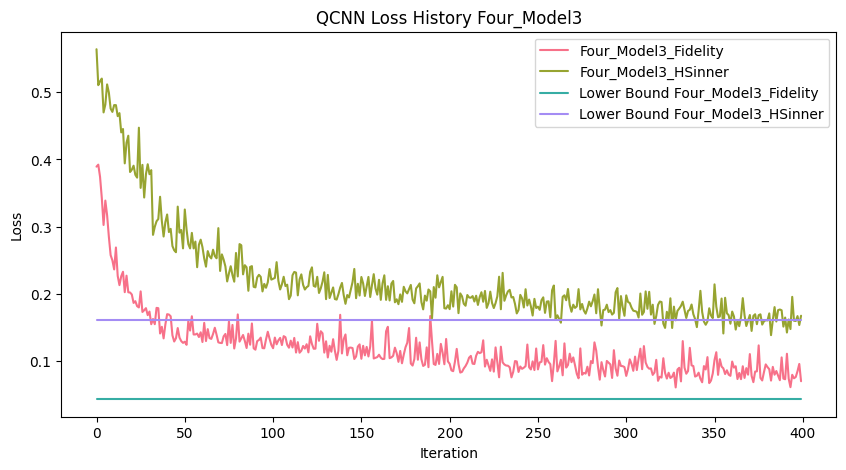

In [19]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 4)
with sns.axes_style("darkgrid"):
    ax.plot(range(len(loss_Four_Model3_Fidelity)), loss_Four_Model3_Fidelity, label="Four_Model3_Fidelity", c=clrs[0])
    ax.plot(range(len(loss_Four_Model3_HSinner)), loss_Four_Model3_HSinner, label="Four_Model3_HSinner", c=clrs[1])

    ax.plot(range(400), np.ones(400) * LB_Four_Model3_Fidelity, label="Lower Bound Four_Model3_Fidelity", c=clrs[2])
    ax.plot(range(400), np.ones(400) * LB_Four_Model3_HSinner, label="Lower Bound Four_Model3_HSinner", c=clrs[3])

ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("QCNN Loss History Four_Model3")
ax.legend()

# 7. Comparison with one fully connected hybrid circuit

In [22]:
weight_shapes = {"weights": (30)}
@qml.qnode(dev)
def Hybrid_QCNN_circuit(inputs, weights):
    Four_QuantumEmbedding2(inputs)
    QCNN_four(weights)
    return qml.expval(qml.PauliZ(2))


class Hybrid_Model3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Layer1: 28 * 28 -> 14 * 14
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 8
        self.fc = torch.nn.Linear(7 * 7, 8, bias=True)
        self.qcnn = qml.qnn.TorchLayer(Hybrid_QCNN_circuit, weight_shapes)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 7 * 7)
        x = self.fc(x)
        x = self.qcnn(x)
        return x

In [37]:
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [43]:
def train_hybrid_models(model_name):
    train_loss = []
    if model_name == 'Hybrid_Model3':
        model = Hybrid_Model3()
        PATH = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noiseless/Model 3/Hybrid_Model3.pt'
    model.train()

    loss_fn = torch.nn.MSELoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.01)
    for it in range(1000):

        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]

        X_batch = torch.tensor(X_batch).to(torch.float32)
        Y_batch = torch.tensor(Y_batch).to(torch.float32)
        X_batch = X_batch.permute(0, 3, 1, 2)


        pred = model(X_batch)
        loss = loss_fn(pred, Y_batch)
        train_loss.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()

        if it % 200 == 0:
            print(f"Iterations: {it} Loss: {loss.item()}")
    
    torch.save(model.state_dict(), PATH)
    return train_loss

loss_Hybrid_Model3 = train_hybrid_models('Hybrid_Model3')

Iterations: 0 Loss: 1.4361954927444458
Iterations: 200 Loss: 0.9673902988433838
Iterations: 400 Loss: 0.057698383927345276
Iterations: 600 Loss: 0.028808098286390305
Iterations: 800 Loss: 0.022165970876812935


In [45]:
PATH = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Noiseless/Model 3/'

f = open(PATH + 'loss_Hybrid_Model3.txt', 'w')
f.write('loss history: \n')
f.write(str(loss_Hybrid_Model3))
f.close()

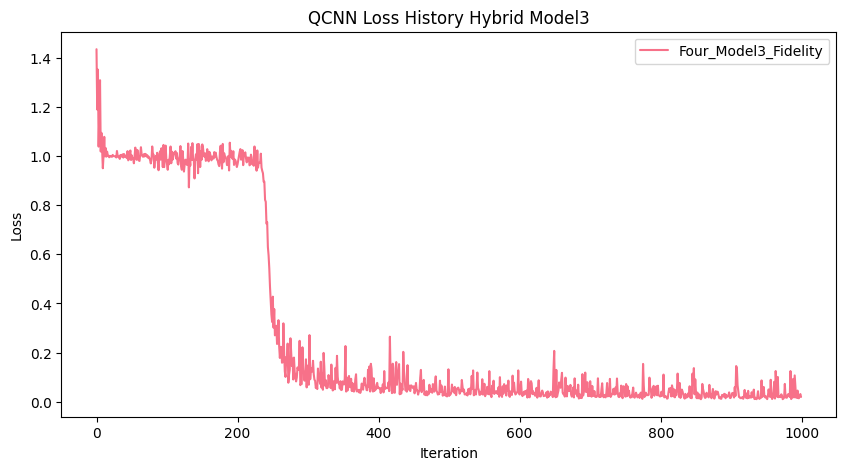

In [46]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 4)
with sns.axes_style("darkgrid"):
    ax.plot(range(len(loss_Hybrid_Model3)), loss_Hybrid_Model3, label="Four_Model3_Fidelity", c=clrs[0])

ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("QCNN Loss History Hybrid Model3")
ax.legend()